# EM shower reconstruction at SND@LHC

1. __make sure the preprocessing has already been done__

2. __make sure `results` folder exists__


based on https://github.com/pauldebryas/SND_trackers_My_data/tree/SNDatLHC_neutrino

https://arxiv.org/pdf/2002.08722.pdf

In [1]:
# imports from utils.py & net.py
from utils import DataPreprocess, Parameters
from net import SNDNet, BNN, MyDataset, digitize_signal, digitize_signal_1d

# python
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pylab as plt
import time
from tqdm import tqdm
from IPython import display

# system
import os
import gc  # Gabage collector interface (to debug stuff)
import sys

# ml
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# dl
import torch
import torch.nn as nn

# bayesian
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, Predictive

Welcome to JupyROOT 6.18/00


In [2]:
# Test to see if cuda is available or not + listed the CUDA devices that are available
try:
    assert(torch.cuda.is_available())
except:
    raise Exception("CUDA is not available")
    
n_devices = torch.cuda.device_count()
print("CUDA devices available:")

for i in range(n_devices):
    print("\t{}\twith CUDA capability {}".format(torch.cuda.get_device_name      (device=i), 
                                                 torch.cuda.get_device_capability(device=i)))

device = torch.device("cuda", 0)

CUDA devices available:
	Quadro RTX 4000	with CUDA capability (7, 5)
	Quadro RTX 4000	with CUDA capability (7, 5)


In [3]:
# Turn off interactive plotting: for long run it screws up everything
plt.ioff()

In [4]:
DETECTOR_PARAMS = Parameters("SNDatLHC")
PATH_NUEL  = "~/snd_data/nue"
PATH_NUMU  = "~/snd_data/numu"
PATH_NUTAU = "~/snd_data/nutau"

# number of planes of the detector
NB_PLANE = len(DETECTOR_PARAMS.snd_params[DETECTOR_PARAMS.configuration]["TT_POSITIONS"])

## Data processing

Here we load and process __pickle__ files. 

In [7]:
from process_pickle import *

In [8]:
#reidx_TT_df, reidx_y_full = load_dataframes(DETECTOR_PARAMS, PATH_NUEL, PATH_NUMU, PATH_NUTAU)


Reading the tt_cleared.pkl & y_cleared.pkl files by chunk of CCDIS and NueEElastic
Before Reduction (file ~/snd_data/nue):
  TT_df  inelastic: 40000
  y_full inelastic: 40000
Before Reduction (file ~/snd_data/numu):
  TT_df  inelastic: 10000
  y_full inelastic: 10000
Before Reduction (file ~/snd_data/nutau):
  TT_df  inelastic: 10000
  y_full inelastic: 10000


In [9]:
#merged_TT_df, merged_y_full = merge_events_arrays(reidx_TT_df, reidx_y_full)

After Reduction  :

Particle type: nuel
  TT_df : 40000
  y_full: 40000
Particle type: numu
  TT_df : 10000
  y_full: 10000
Particle type: nutau
  TT_df : 10000
  y_full: 10000

Combined TT_df : 60000
Combined y_full: 60000


In [10]:
#merged_y_full = normalise_target_energy(merged_y_full)

## Data preparation

Here we prepare (load or, if needed, create) the datasets.

In [9]:
from operate_datasets import *

In [10]:
# create_dataset('sum', DETECTOR_PARAMS, PATH_NUEL, PATH_NUMU, PATH_NUTAU)

In [11]:
# create_dataset('longitudal', DETECTOR_PARAMS, PATH_NUEL, PATH_NUMU, PATH_NUTAU)

In [12]:
# create_dataset('projection', DETECTOR_PARAMS, PATH_NUEL, PATH_NUMU, PATH_NUTAU)

In [13]:
# memory troubles!
# be very carefull when using this
### create_dataset('plane', DETECTOR_PARAMS, PATH_NUEL, PATH_NUMU, PATH_NUTAU)

## Model quality visualisation

In [14]:
from model_visualisation import *

In [15]:
from sklearn.metrics import *

def get_scores(y_train, y_pred):
    # https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics
    score_func_arr = [explained_variance_score,
                      max_error,
                      mean_absolute_error,
                      mean_squared_error,
                      mean_squared_log_error, 
                      #mean_absolute_percentage_error, # update scikit to use
                      median_absolute_error,
                      r2_score]

    metric_func = explained_variance_score
    
    scores_dict = dict()

    for metric_func in score_func_arr:
        scores_dict[metric_func.__name__] = metric_func(y_train, y_pred)
        print(metric_func.__name__, metric_func(y_train, y_pred))
        
    return scores_dict

# Load datasets

In [16]:
def dataset_split(full_X, full_y):
    data_size = full_X.shape[0]

    # Train test split
    TRAIN_SIZE_RATIO = 0.9
    RANDOM_SEED = 1543

    all_idx = np.arange(0, data_size)

    train_idx, test_idx, _, _ = train_test_split(all_idx, all_idx, 
                                                 train_size=TRAIN_SIZE_RATIO, 
                                                 random_state=RANDOM_SEED)

    train_size = len(train_idx)
    test_size  = len(test_idx)

    X_train = full_X[train_idx]
    y_train = full_y[train_idx]

    X_test = full_X[test_idx]
    y_test = full_y[test_idx]
    
    return X_train, y_train

In [17]:
def dataset_clip(X_arr, y_arr, min_clip):
    clip_idx = np.where(X_arr > min_clip)[0]

    X_arr_clip = X_arr[clip_idx]#.reshape(-1, 1)
    y_arr_clip = y_arr[clip_idx]#.reshape(-1, 1)

    return X_arr_clip, y_arr_clip

## Linear regression on true hits

In [18]:
reidx_TT_df, reidx_y_full = load_dataframes(DETECTOR_PARAMS, PATH_NUEL, PATH_NUMU, PATH_NUTAU)
merged_TT_df, merged_y_full = merge_events_arrays(reidx_TT_df, reidx_y_full)
merged_y_full = normalise_target_energy(merged_y_full)


Reading the tt_cleared.pkl & y_cleared.pkl files by chunk of CCDIS and NueEElastic
Before Reduction (file ~/snd_data/nue):
  TT_df  inelastic: 10000
  y_full inelastic: 10000
Before Reduction (file ~/snd_data/numu):
  TT_df  inelastic: 10000
  y_full inelastic: 10000
Before Reduction (file ~/snd_data/nutau):
  TT_df  inelastic: 10000
  y_full inelastic: 10000
After Reduction  :

Particle type: nuel
  TT_df : 10000
  y_full: 10000
Particle type: numu
  TT_df : 10000
  y_full: 10000
Particle type: nutau
  TT_df : 10000
  y_full: 10000

Combined TT_df : 30000
Combined y_full: 30000


In [19]:
merged_TT_df.columns # no muons yet ... !!!

Index(['PX', 'PY', 'PZ', 'X', 'Y', 'Z', 'PdgCode'], dtype='object')

In [20]:
# is this how we get true hits ???

merged_TT_df['TrueHits'] = (0)

for i in range(merged_TT_df['X'].shape[0]):
    merged_TT_df['TrueHits'][i] = merged_TT_df['X'][i].shape[0]
    
true_hits_X = merged_TT_df['TrueHits'].to_numpy()

/home/fsergeev/anaconda3/envs/ship_tt/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [21]:
full_X, full_y = load_dataset('~/snd_data/new_dataset/', 'sum')

In [22]:
full_X = true_hits_X

In [23]:
X_train, y_train = dataset_split(full_X, full_y)

# no clipping for true hits
#X_train, y_train = dataset_clip(X_train, y_train, min_clip)

In [24]:
X_train.shape[0] - np.count_nonzero(X_train)

16796

In [25]:
from sklearn.linear_model import LinearRegression

X_train = X_train.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)

reg_l2 = LinearRegression().fit(X_train, y_train) # positive=True ??? (update sklearn)
score_l2 = reg_l2.score(X_train, y_train)

print('L2: ', score_l2)

y_pred_l2 = reg_l2.predict(X_train)

L2:  0.0047386087144241085


In [26]:
def plot_res_hist_custom(y_true, y_pred):
    resolution = np.divide(y_pred - y_true, y_true)
    
    fig, ax = plt.subplots(figsize=(8,6))

    plt.xlim(-2, 20)
    ax.hist(resolution.reshape(-1), bins = 1800)
    
    plt.xlabel(r'$(E_{reco} - E_{true})~/~E_{true}$')
    plt.ylabel('# particles')

    plt.show()

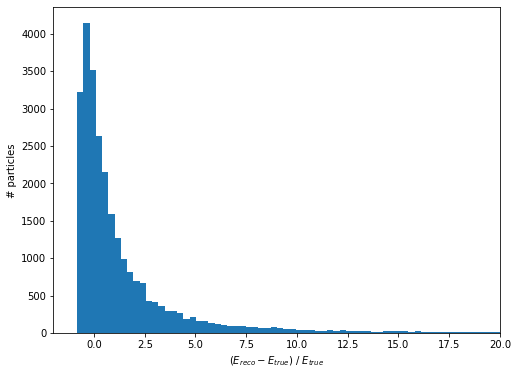

In [27]:
plot_res_hist_custom(y_train, y_pred_l2)

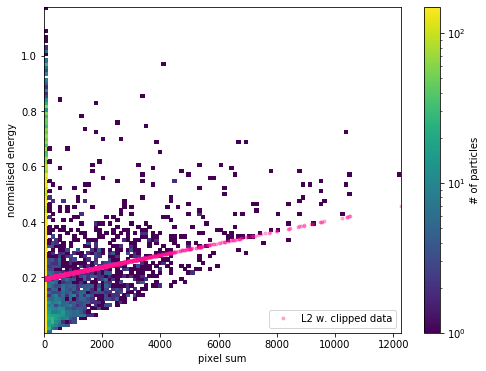

In [28]:
plot_2d_energy_hist(X_train, y_train, y_pred_l2)

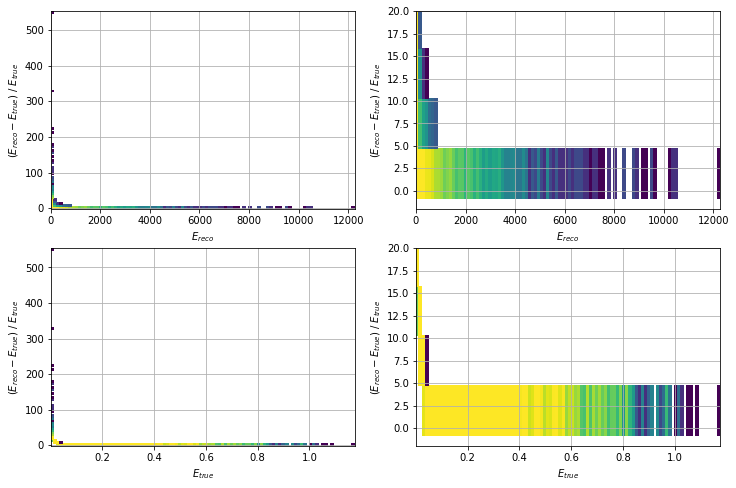

In [29]:
plot_res_vs_energy(X_train, y_train, y_pred_l2) 

## Support vector regression baseline

In [30]:
full_X, full_y = load_dataset('~/snd_data/new_dataset/', 'longitudal')
min_clip = 25

X_train, y_train = dataset_split(full_X, full_y)
X_train, y_train = dataset_clip(X_train, y_train, min_clip)

In [31]:
from sklearn import svm

reg_svr = svm.SVR(gamma='scale')
#reg_svr = svm.LinearSVR(max_iter=10**5)

reg_svr.fit(X_train, y_train)

score_svr = reg_svr.score(X_train, y_train)

print('SVM: ', score_svr)

y_pred_svr = reg_svr.predict(X_train)

SVM:  0.4880231440011321


In [32]:
X_sum = X_train.sum(axis=1).reshape(-1,1)
y_sum = y_train.reshape(-1,1)
y_pred_svr = y_pred_svr.reshape(-1,1)

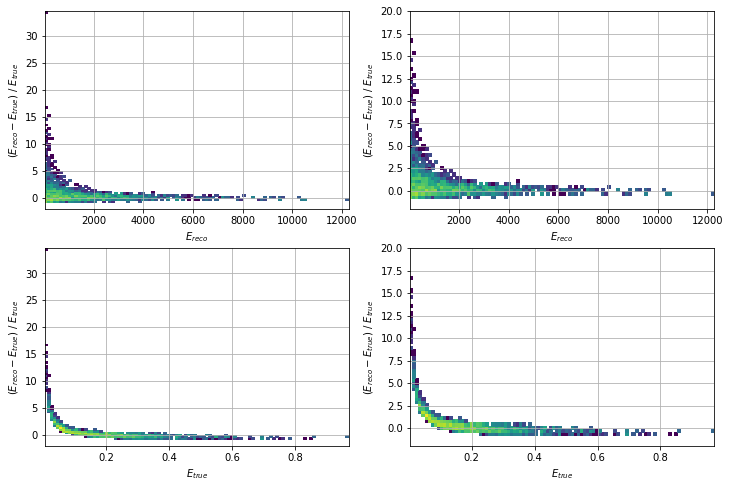

In [33]:
plot_res_vs_energy(X_sum, y_sum, y_pred_svr) 

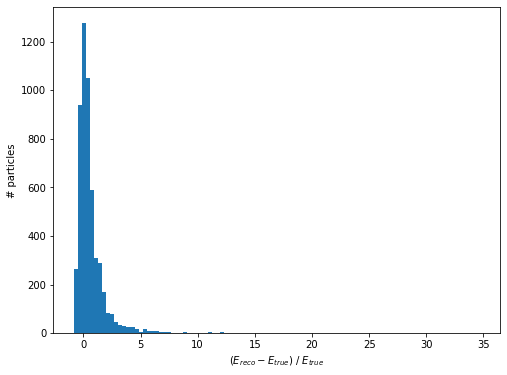

In [34]:
plot_res_hist(y_sum, y_pred_svr)

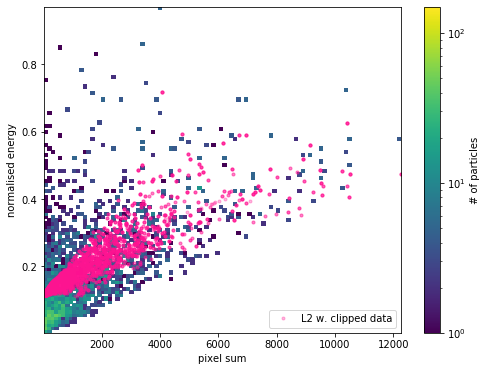

In [35]:
plot_2d_energy_hist(X_sum, y_sum, y_pred_svr)

In [36]:
get_scores(y_sum, y_pred_svr)

explained_variance_score 0.5018144715673952
max_error 0.6758947121300283
mean_absolute_error 0.07527675865873688
mean_squared_error 0.009606881636940881
mean_squared_log_error 0.006104335751157342
median_absolute_error 0.06983909554033953
r2_score 0.4880231440011321


{'explained_variance_score': 0.5018144715673952,
 'max_error': 0.6758947121300283,
 'mean_absolute_error': 0.07527675865873688,
 'mean_squared_error': 0.009606881636940881,
 'mean_squared_log_error': 0.006104335751157342,
 'median_absolute_error': 0.06983909554033953,
 'r2_score': 0.4880231440011321}

In [37]:
frac_resol = np.divide((y_pred_svr - y_sum), y_sum)

print((frac_resol < 0).sum())
print((frac_resol >= 0).sum())

1599
3725


## Linear regression baseline

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

In [39]:
full_X, full_y = load_dataset('~/snd_data/new_dataset/', 'sum')
min_clip = 25

X_train, y_train = dataset_split(full_X, full_y)
X_train, y_train = dataset_clip(X_train, y_train, min_clip)

In [40]:
X_train = X_train.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)

In [41]:
reg_l2 = LinearRegression()   .fit(X_train, y_train) # positive=True ???
#reg_l1 = Lasso(positive=False).fit(X_train, y_train) # positive=True ???

score_l2 = reg_l2.score(X_train.reshape(-1, 1), y_train)

print('L2: ', score_l2)

y_pred_l2 = reg_l2.predict(X_train)

L2:  0.2362499696823066


In [42]:
reg_l2.coef_

array([[4.3983722e-05]])

In [43]:
reg_l2.intercept_

array([0.12239027])

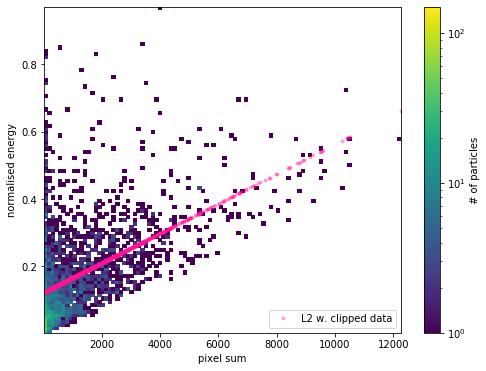

In [44]:
plot_2d_energy_hist(X_train, y_train, y_pred_l2) 

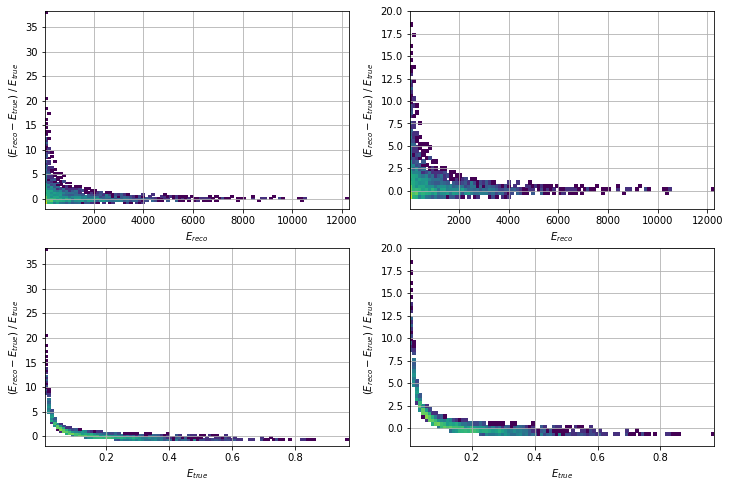

In [45]:
plot_res_vs_energy(X_train, y_train, y_pred_l2) 

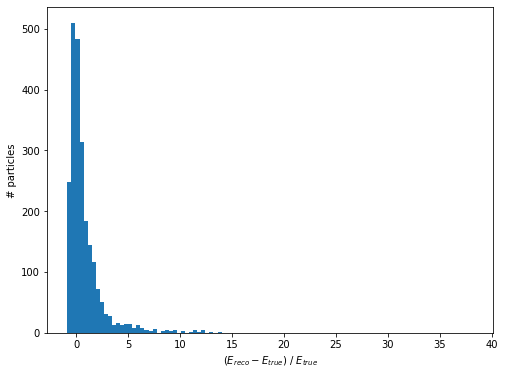

In [46]:
plot_res_hist(y_train, y_pred_l2)

In [47]:
get_scores(y_train, y_pred_l2)

explained_variance_score 0.2362499696823066
max_error 0.7200595932073045
mean_absolute_error 0.08855144221650643
mean_squared_error 0.015148897907780986
mean_squared_log_error 0.009410966036480279
median_absolute_error 0.07579413544166627
r2_score 0.2362499696823066


{'explained_variance_score': 0.2362499696823066,
 'max_error': 0.7200595932073045,
 'mean_absolute_error': 0.08855144221650643,
 'mean_squared_error': 0.015148897907780986,
 'mean_squared_log_error': 0.009410966036480279,
 'median_absolute_error': 0.07579413544166627,
 'r2_score': 0.2362499696823066}

## Stochastic regression

In [48]:
full_X, full_y = load_dataset('~/snd_data/new_dataset/', 'sum')
min_clip = 25

X_train, y_train = dataset_split(full_X, full_y)
X_train, y_train = dataset_clip(X_train, y_train, min_clip)

In [49]:
X_train = torch.tensor(X_train).float().reshape(-1,1)
y_train = torch.tensor(y_train).float().reshape(-1)

In [50]:
from pyro.distributions import constraints


class BayesianRegression(PyroModule):
    def __init__(self):
        super().__init__()
        self.linear = PyroModule[nn.Linear](1, 1)
        
        # prior over parameters
        self.linear.weight = PyroSample(dist.Normal(1e-4, 5e-5).expand([1, 1]).to_event(2))
        self.linear.bias   = PyroSample(dist.Normal(1e-1, 5e-2).expand([1]).to_event(1))
        return
    
    def forward(self, x, y=None):
        # energy (from the model)
        mean = self.linear(x).squeeze(-1)
        
        # noise (learnable)
        sigma = pyro.sample("sigma", dist.Uniform(0., 1.)) 
        
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        
        return mean

In [51]:
def model(x, y=None):
    bias   = pyro.sample("bias",   dist.Normal(1e-4, 1e-4))
    weight = pyro.sample("weight", dist.Normal(0.1, 0.1))

    mean = bias + weight * x # + mu_weight * muon_hits
    mean = mean.squeeze(-1)
    sigma = pyro.sample("sigma", dist.Uniform(0., 0.1)) 

    with pyro.plate("data", x.shape[0]):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=y)

    return mean


def guide(x, y=None):
    b_loc   = pyro.param("b_loc",   torch.tensor(1e-4), constraint=constraints.positive)
    b_scale = pyro.param("b_scale", torch.tensor(1e-4), constraint=constraints.positive)

    w_loc   = pyro.param("w_loc",   torch.tensor(0.1), constraint=constraints.positive)
    w_scale = pyro.param("w_scale", torch.tensor(0.1), constraint=constraints.positive)

    bias =   pyro.sample("bias",   dist.Normal(b_loc, b_scale))
    weight = pyro.sample("weight", dist.Normal(w_loc, w_scale))

    #sigma_loc = pyro.param('sigma_loc', torch.tensor(5.))
    sigma = pyro.sample("sigma", dist.Normal(0.05, 0.005))

    mean = bias + weight * x
    
    return mean

In [52]:
reg_model = model # BayesianRegression()
reg_guide = guide # AutoDiagonalNormal(model)

num_steps = 50
initial_lr = 1.0
gamma = 0.5  # final learning rate will be gamma * initial_lr
lrd = gamma ** (1 / num_steps)

adam = pyro.optim.ClippedAdam({"lr": initial_lr, 'lrd': lrd})

#adam = pyro.optim.ClippedAdam({"lr": 1.0, "lrd": 0.5})
svi = SVI(reg_model, reg_guide, adam, loss=Trace_ELBO())
num_iterations = 200

pyro.clear_param_store()
loss_arr = []


for j in range(num_iterations):
    loss = svi.step(X_train, y_train)

    loss_arr.append(loss)
        
    if j % 25 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(X_train)))

[iteration 0001] loss: 8857857.7424
[iteration 0026] loss: 4.1362
[iteration 0051] loss: 2.1607
[iteration 0076] loss: 1.8690
[iteration 0101] loss: 2.9150
[iteration 0126] loss: 2.6293
[iteration 0151] loss: 2.6420
[iteration 0176] loss: 1.5807


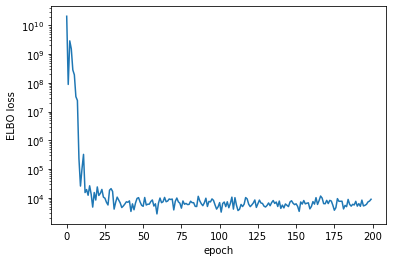

In [65]:
plt.plot(loss_arr)
plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('ELBO loss')
plt.show()

In [54]:
#guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

b_loc tensor(3.0392e-09, grad_fn=<AddBackward0>)
b_scale tensor(0.0001, grad_fn=<AddBackward0>)
w_loc tensor(8.2355e-05, grad_fn=<AddBackward0>)
w_scale tensor(5.3484e-07, grad_fn=<AddBackward0>)


In [55]:
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        site_stats[site_name] = {
            "mean": torch.mean(values, 0),
            "std" : torch.std (values, 0),
            "5%"  : values.kthvalue(int(len(values) * 0.05), dim=0)[0],
            "95%" : values.kthvalue(int(len(values) * 0.95), dim=0)[0],
        }
        
    return site_stats


predictive = Predictive(model, guide=guide, num_samples=800)
samples = predictive(X_train)
pred_summary = summary(samples)

In [56]:
pred_summary

{'bias': {'mean': tensor([-1.8149e-06]),
  'std': tensor([0.0001]),
  '5%': tensor([-0.0002]),
  '95%': tensor([0.0002])},
 'weight': {'mean': tensor([8.2394e-05]),
  'std': tensor([5.5416e-07]),
  '5%': tensor([8.1490e-05]),
  '95%': tensor([8.3303e-05])},
 'sigma': {'mean': tensor([0.0498]),
  'std': tensor([0.0050]),
  '5%': tensor([0.0413]),
  '95%': tensor([0.0584])},
 'obs': {'mean': tensor([0.0424, 0.1313, 0.2120,  ..., 0.0010, 0.6588, 0.1130]),
  'std': tensor([0.0506, 0.0505, 0.0517,  ..., 0.0500, 0.0492, 0.0487]),
  '5%': tensor([-0.0390,  0.0451,  0.1199,  ..., -0.0784,  0.5798,  0.0353]),
  '95%': tensor([0.1287, 0.2163, 0.2927,  ..., 0.0828, 0.7384, 0.1936])}}

In [57]:
mu = pred_summary["obs"]
y = pred_summary["obs"]
predictions = pd.DataFrame({
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
})

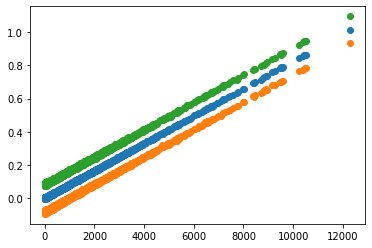

In [58]:
plt.plot(X_train[:,0], predictions['mu_mean'].to_numpy(), 'o')
plt.plot(X_train[:,0], predictions['mu_perc_5'].to_numpy(), 'o')
plt.plot(X_train[:,0], predictions['mu_perc_95'].to_numpy(), 'o')
plt.show()

In [59]:
predictions['mu_mean']

0       0.042361
1       0.131310
2       0.211989
3       0.065034
4       0.101034
          ...   
2347    0.067562
2348    0.006394
2349    0.001015
2350    0.658770
2351    0.113003
Name: mu_mean, Length: 2352, dtype: float32

In [60]:
def plot_2d_energy_hist(X_arr, y_true, predictions):
    fig, ax = plt.subplots(figsize=(8,6))

    y_pred_min  = predictions["mu_perc_5"].to_numpy()
    y_pred_mean = predictions["mu_mean"]  .to_numpy()
    y_pred_max  = predictions["mu_perc_95"].to_numpy()
    
    print(X_arr.shape)
    print(y_true.shape)
    
    hist = ax.hist2d(X_arr[:,0].numpy(), y_true.numpy(), 
                     bins=100, norm=mpl.colors.LogNorm(), vmax=150)
    
    plt.ylim(0)
    plt.xlabel('pixel sum')
    plt.ylabel('normalised energy')

    #plt.axvline(x=min_clip, c='m', alpha=0.9, label='Min clip ' + str(min_clip))
    ax.plot(X_arr[:, 0], y_pred_mean, 'g.', alpha=0.3, label='L2 w. clipped data')
    ax.plot(X_arr[:, 0], y_pred_min, 'r.', marker='.', alpha=0.3, label='5%')
    ax.plot(X_arr[:, 0], y_pred_max, 'b.', marker='.', alpha=0.3, label='95%')
    #ax.fill_between(X_arr[:, 0], y_pred_min, y_pred_max,  alpha=0.3, color='deeppink')

    #cbar = fig.colorbar(hist[3], ax=ax)
    #|cbar.set_label('# of particles')

    plt.legend(loc='lower right')
    plt.show()

torch.Size([2352, 1])
torch.Size([2352])


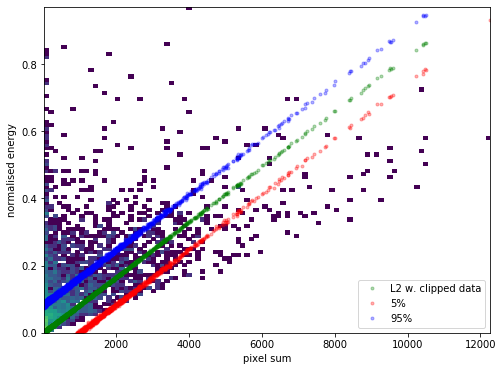

In [61]:
plot_2d_energy_hist(X_train, y_train, predictions) 

## Muon detector

In [27]:
def load_one_dataframe(params, path_nu):
    proc_path_nu  = os.path.expandvars(path_nu)
        
    step_size = 4000                   # events in one file
    files_num = 100                    # number of files
    file_size = files_num * step_size  # total number of events
    
    reidx_TT_df, reidx_y_full = read_chunklist(path_nu, step_size, file_size)
    
    return reidx_TT_df, reidx_y_full

In [33]:
from operate_datasets import *

def create_nu_dataset(mode, detector_params, path_nu, used_data_coef = 1.0):
    
    X_arr, y_arr = load_one_dataframe(detector_params, path_nu)
        
    dataset_fname = 'big_nue_dataset.npz'

    full_X, full_y = make_dataset(X_arr, y_arr, detector_params,
                                  used_data_coef = used_data_coef,
                                  sgn_dgt_mode = SGN_DGT_MODES[mode])

    save_dataset(full_X, full_y, dataset_fname)
        
    return


In [34]:
create_nu_dataset('sum', DETECTOR_PARAMS, PATH_NUEL)

Before Reduction (file ~/snd_data/nue):


  0%|          | 110/399000 [00:00<06:19, 1051.71it/s]

  TT_df  inelastic: 399000
  y_full inelastic: 399000


100%|██████████| 399000/399000 [04:05<00:00, 1624.96it/s]


In [36]:
def load_dataset(path, mode='sum'):
    assert mode in SGN_DGT_MODE_NAMES
    
    dataset_fname = 'big_nue_dataset.npz'

    full_X, full_y = None, None

    # load if exists
    full_dts = None

    with open(dataset_fname, 'rb') as file:
        full_dts = np.load(file)#, allow_pickle=True)

        full_X = full_dts['x']
        full_y = full_dts['y']
        
    return full_X, full_y

In [37]:
full_X, full_y = load_dataset('', 'sum')

In [38]:
full_X

array([2.909e+03, 0.000e+00, 1.570e+02, ..., 0.000e+00, 2.000e+00,
       2.000e+00])